In [ ]:
import sys
import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# UMAP（非線性降維）
try:
    from umap import UMAP
    UMAP_OK = True
except Exception:
    try:
        from umap.umap_ import UMAP  # 某些環境的模組路徑
        UMAP_OK = True
    except Exception:
        UMAP_OK = False
        print("⚠️ 未安裝 umap-learn，請先安裝：pip install umap-learn")

# 統計檢驗
try:
    from scipy.stats import mannwhitneyu, ks_2samp
    SCIPY_OK = True
except Exception:
    SCIPY_OK = False

# 機器學習相關
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import (
    StratifiedKFold, cross_val_score, GridSearchCV, 
    train_test_split, cross_validate
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, classification_report,
    precision_recall_curve, f1_score, confusion_matrix, roc_curve,
    make_scorer
)
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline

# 設定繪圖風格
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
# ==================== 路徑設定 ====================
BASE_DIR  = Path(r"D:\FLY114")
XLSX_PATH = BASE_DIR / "Diagnosis and autonomic marker data for VNS research_20250813.xlsx"
OUT_DIR   = BASE_DIR / "Data_Improved"
PLOTS_DIR = OUT_DIR / "enhanced_plots"
OUT_XLSX  = OUT_DIR / "enhanced_analysis_summary.xlsx"
MODELS_DIR = OUT_DIR / "models"

for d in [OUT_DIR, PLOTS_DIR, MODELS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

SHEET_NAME = "Sheet1"

# ==================== 欄位定義 ====================
BASIC_COLS   = ["Age", "Sex", "BMI"]
LABEL_COLS   = ["SSD", "MDD", "Panic", "GAD"]
CONTROL_COLS = ["DM", "TCA", "MARTA"]
HRV_COLS     = ["SDNN", "LF", "HF", "LFHF", "SC", "FT", "RSA"]
ALL_FEATURES = BASIC_COLS + CONTROL_COLS + HRV_COLS

SCALE_MAP = {
    "Sex":"Nominal", "SSD":"Nominal", "MDD":"Nominal", "Panic":"Nominal", "GAD":"Nominal",
    "DM":"Nominal", "TCA":"Nominal", "MARTA":"Nominal",
    "Age":"Ratio", "BMI":"Ratio", "SDNN":"Ratio", "LF":"Ratio", "HF":"Ratio",
    "LFHF":"Ratio", "SC":"Ratio", "FT":"Interval", "RSA":"Ratio"
}

print("=" * 80)
print("增強版機器學習分析流程")
print("=" * 80)

增強版機器學習分析流程


In [3]:
# ==================== 1. 載入資料 ====================
print("\n[1] 載入資料...")
df = pd.read_excel(XLSX_PATH, sheet_name=SHEET_NAME)
df.columns = [c.strip() for c in df.columns]
print(f"原始資料形狀: {df.shape}")

# ==================== 2. 資料清理 ====================
print("\n[2] 資料清理...")

# 型別轉換
for c in [*ALL_FEATURES, *LABEL_COLS]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# 處理 Sex 欄位
if "Sex" in df.columns and df["Sex"].dtype == object:
    norm = df["Sex"].astype(str).str.lower().str[0].map({"m":1, "f":0})
    if norm.notna().mean() > 0.6:
        df["Sex"] = norm

# LFHF 應該 >= 0
if "LFHF" in df.columns:
    df.loc[df["LFHF"] < 0, "LFHF"] = np.nan

# 移除極端離群值 (使用 IQR 方法)
def remove_outliers_iqr(df, cols, factor=3.0):
    """使用 IQR 方法處理離群值，較溫和的方法"""
    df_clean = df.copy()
    for col in cols:
        if col in df_clean.columns:
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - factor * IQR
            upper = Q3 + factor * IQR
            outliers = ((df_clean[col] < lower) | (df_clean[col] > upper))
            n_outliers = outliers.sum()
            if n_outliers > 0:
                print(f"  {col}: 發現 {n_outliers} 個離群值，設為缺失值")
                df_clean.loc[outliers, col] = np.nan
    return df_clean

numerical_cols = [c for c in HRV_COLS + ["Age", "BMI"] if c in df.columns]
df = remove_outliers_iqr(df, numerical_cols, factor=3.0)

print(f"清理後資料形狀: {df.shape}")


[1] 載入資料...
原始資料形狀: (502, 17)

[2] 資料清理...
  SDNN: 發現 24 個離群值，設為缺失值
  LF: 發現 53 個離群值，設為缺失值
  HF: 發現 51 個離群值，設為缺失值
  LFHF: 發現 28 個離群值，設為缺失值
  SC: 發現 19 個離群值，設為缺失值
  FT: 發現 1 個離群值，設為缺失值
  RSA: 發現 25 個離群值，設為缺失值
  BMI: 發現 2 個離群值，設為缺失值
清理後資料形狀: (502, 17)


In [4]:
# ==================== 3. 特徵工程 ====================
print("\n[3] 特徵工程...")

# 新增交互特徵
if all(c in df.columns for c in ["LF", "HF"]):
    df["LF_HF_ratio"] = df["LF"] / (df["HF"] + 1e-9)
    df["LF_plus_HF"] = df["LF"] + df["HF"]
    print("  新增特徵: LF_HF_ratio, LF_plus_HF")

if all(c in df.columns for c in ["Age", "BMI"]):
    df["Age_BMI_interaction"] = df["Age"] * df["BMI"]
    print("  新增特徵: Age_BMI_interaction")

if "SDNN" in df.columns and "SC" in df.columns:
    df["SDNN_SC_ratio"] = df["SDNN"] / (df["SC"] + 1e-9)
    print("  新增特徵: SDNN_SC_ratio")

# 更新特徵列表
ENGINEERED_FEATURES = ["LF_HF_ratio", "LF_plus_HF", "Age_BMI_interaction", "SDNN_SC_ratio"]
ALL_FEATURES_EXT = ALL_FEATURES + [f for f in ENGINEERED_FEATURES if f in df.columns]


[3] 特徵工程...
  新增特徵: LF_HF_ratio, LF_plus_HF
  新增特徵: Age_BMI_interaction
  新增特徵: SDNN_SC_ratio


In [5]:
# ==================== 4. 改進的缺失值處理 ====================
print("\n[4] 缺失值處理...")

missing_report = pd.DataFrame({
    'column': [c for c in ALL_FEATURES_EXT if c in df.columns],
    'missing_count': [df[c].isna().sum() for c in ALL_FEATURES_EXT if c in df.columns],
    'missing_ratio': [df[c].isna().sum()/len(df) for c in ALL_FEATURES_EXT if c in df.columns]
})
print("\n缺失值報告:")
print(missing_report.sort_values('missing_ratio', ascending=False))

# 使用 KNN Imputer 進行更智慧的缺失值填補
def smart_impute(df, feature_cols, strategy='knn', n_neighbors=5):
    """智慧缺失值填補"""
    df_imputed = df.copy()
    
    # 分離類別型和數值型特徵
    categorical = [c for c in feature_cols if c in ['Sex', 'DM', 'TCA', 'MARTA']]
    numerical = [c for c in feature_cols if c not in categorical]
    
    # 類別型: 使用眾數
    if categorical:
        imp_cat = SimpleImputer(strategy='most_frequent')
        df_imputed[categorical] = imp_cat.fit_transform(df[categorical])
    
    # 數值型: 使用 KNN 或中位數
    if numerical:
        if strategy == 'knn' and len(df) > 10:
            imp_num = KNNImputer(n_neighbors=min(n_neighbors, len(df)//2))
        else:
            imp_num = SimpleImputer(strategy='median')
        
        df_imputed[numerical] = imp_num.fit_transform(df[numerical])
    
    return df_imputed

# 對每個診斷標籤保留有效樣本
valid_samples = {}
for label in LABEL_COLS:
    if label in df.columns:
        # 保留該標籤非缺失的樣本
        mask = df[label].notna()
        valid_samples[label] = mask
        print(f"  {label}: {mask.sum()} 個有效樣本")


[4] 缺失值處理...

缺失值報告:
                 column  missing_count  missing_ratio
14           LF_plus_HF             63       0.125498
13          LF_HF_ratio             63       0.125498
7                    LF             53       0.105578
8                    HF             51       0.101594
16        SDNN_SC_ratio             43       0.085657
9                  LFHF             28       0.055777
12                  RSA             25       0.049801
6                  SDNN             24       0.047809
10                   SC             19       0.037849
2                   BMI              2       0.003984
15  Age_BMI_interaction              2       0.003984
11                   FT              1       0.001992
5                 MARTA              0       0.000000
4                   TCA              0       0.000000
1                   Sex              0       0.000000
3                    DM              0       0.000000
0                   Age              0       0.000000
  SSD:

In [6]:
# ==================== 5. 改進的 PCA 分析 ====================
print("\n[5] 改進的 PCA 分析...")

hrv_cols_available = [c for c in HRV_COLS if c in df.columns]
X_pca = df[hrv_cols_available].copy()

# 填補缺失值
imp = KNNImputer(n_neighbors=5)
X_pca_filled = pd.DataFrame(
    imp.fit_transform(X_pca),
    columns=X_pca.columns,
    index=X_pca.index
)

# 使用 RobustScaler (對離群值更穩健)
scaler = RobustScaler()
X_pca_scaled = scaler.fit_transform(X_pca_filled)

# PCA with more components
pca = PCA(random_state=42)
X_pca_transformed = pca.fit_transform(X_pca_scaled)

# 解釋變異量
explained_var = pd.DataFrame({
    'PC': [f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
    'Explained_Variance_Ratio': pca.explained_variance_ratio_,
    'Cumulative_Variance': np.cumsum(pca.explained_variance_ratio_)
})
print("\nPCA 解釋變異量:")
print(explained_var.head(10))


[5] 改進的 PCA 分析...

PCA 解釋變異量:
    PC  Explained_Variance_Ratio  Cumulative_Variance
0  PC1                  0.557316             0.557316
1  PC2                  0.163877             0.721193
2  PC3                  0.125902             0.847095
3  PC4                  0.077201             0.924296
4  PC5                  0.039472             0.963768
5  PC6                  0.022317             0.986085
6  PC7                  0.013915             1.000000


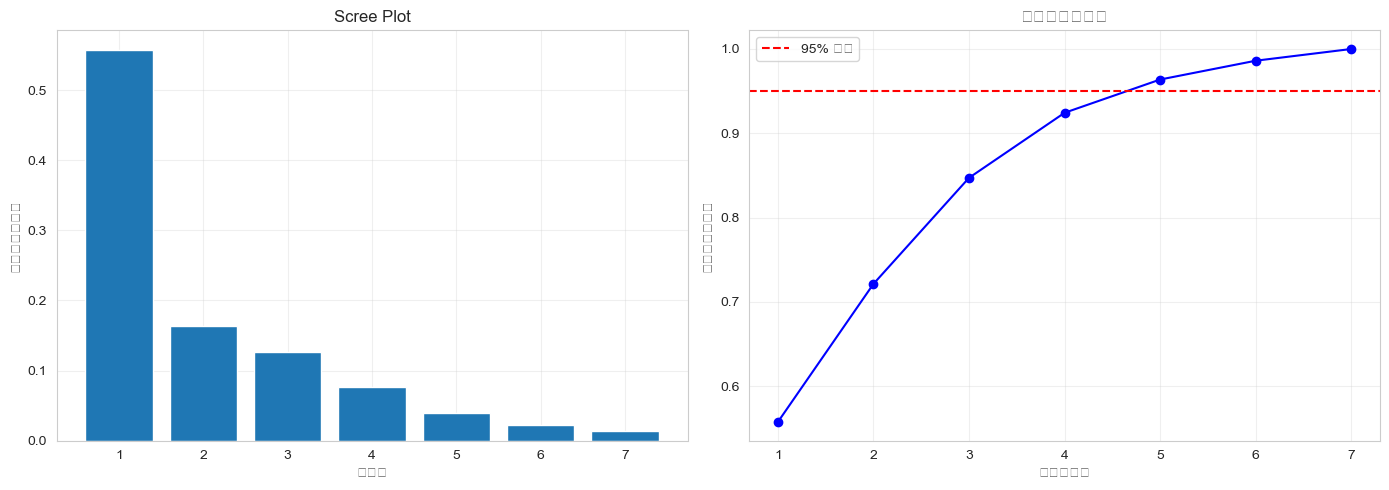

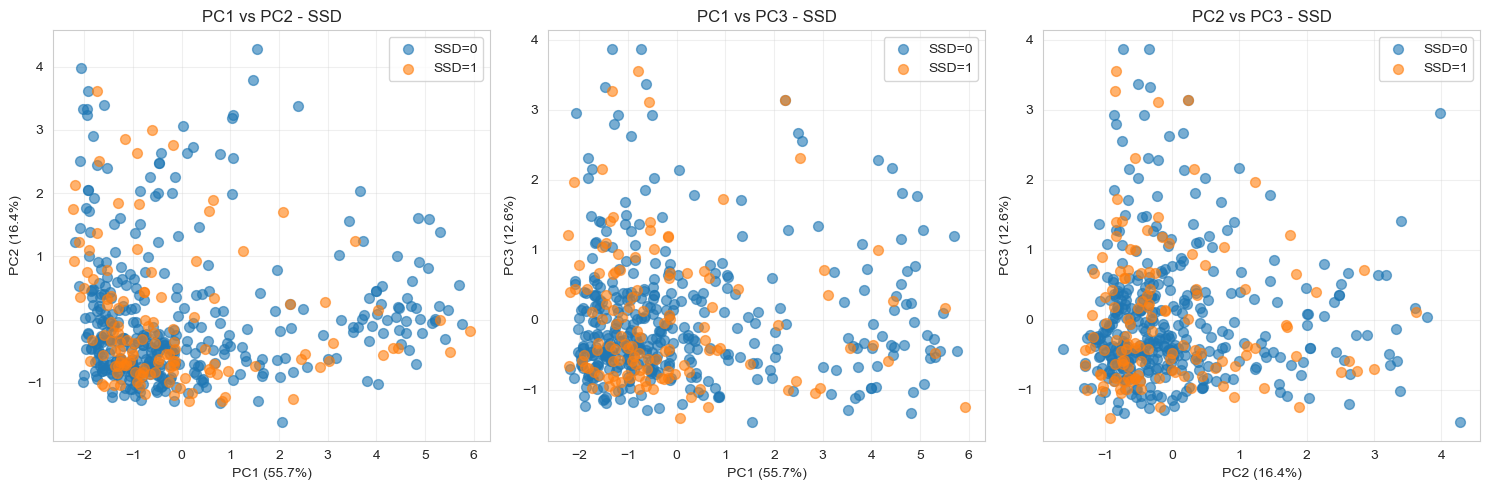

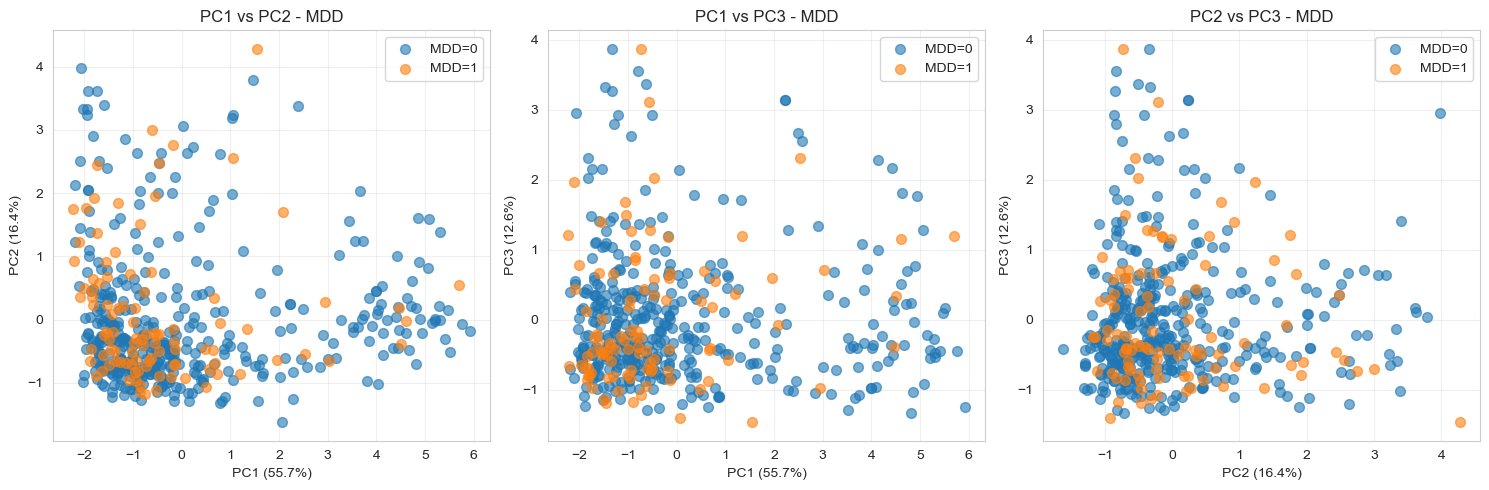

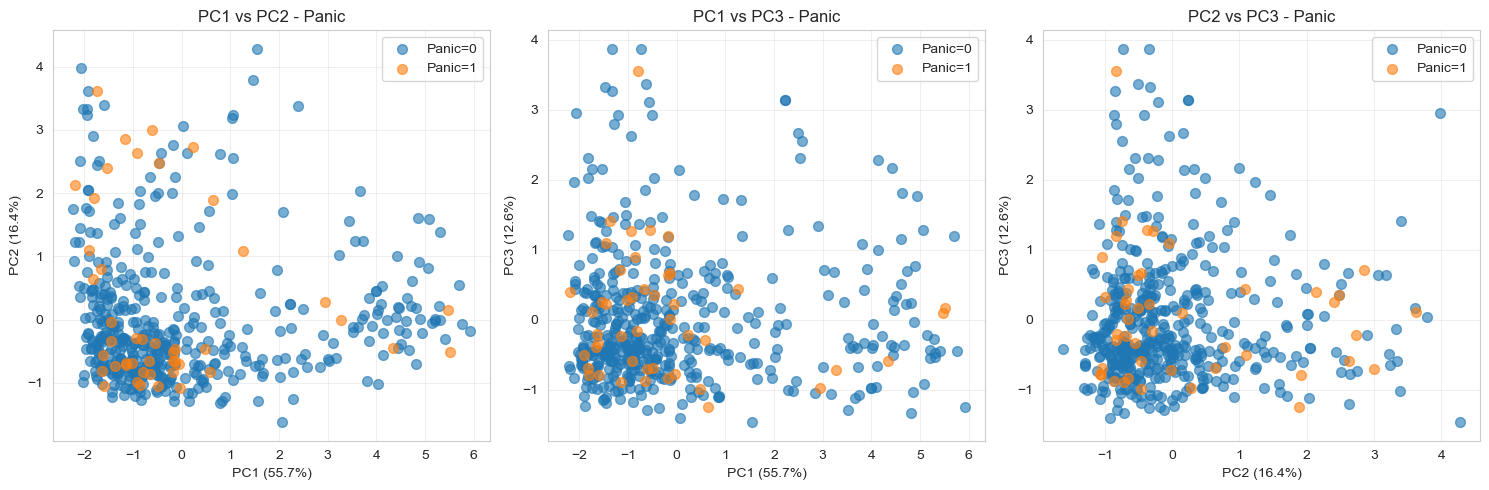

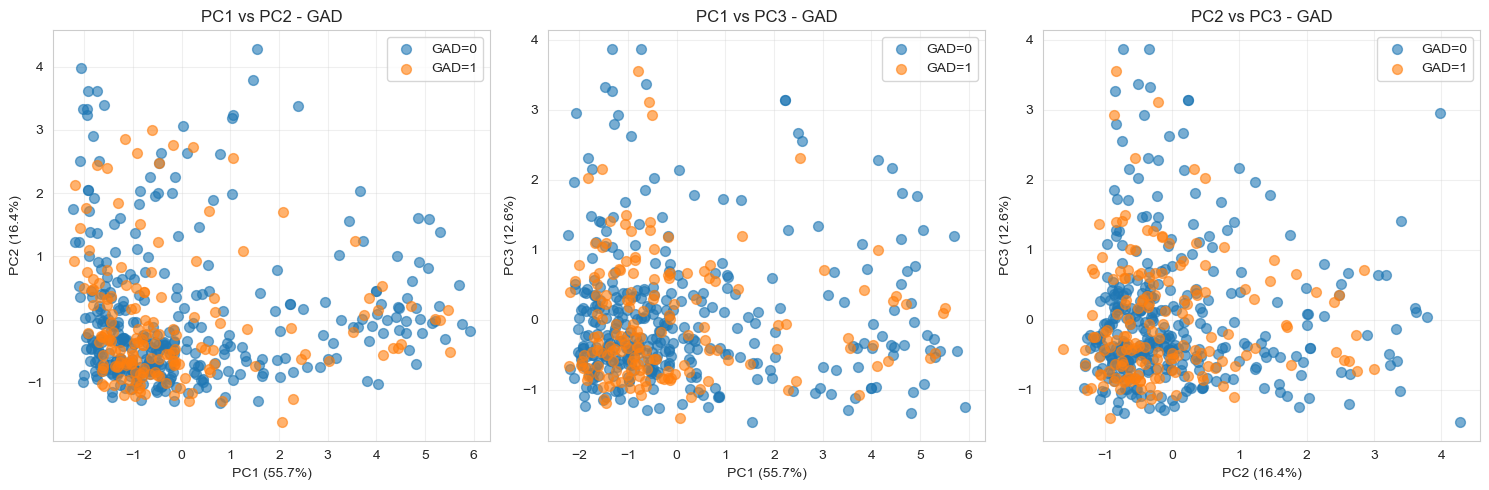

In [7]:
# 視覺化解釋變異量
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
ax1.bar(range(1, min(11, len(pca.explained_variance_ratio_)+1)), 
        pca.explained_variance_ratio_[:10])
ax1.set_xlabel('主成分')
ax1.set_ylabel('解釋變異量比例')
ax1.set_title('Scree Plot')
ax1.grid(True, alpha=0.3)

# Cumulative variance
ax2.plot(range(1, len(pca.explained_variance_ratio_)+1), 
         np.cumsum(pca.explained_variance_ratio_), 'bo-')
ax2.axhline(y=0.95, color='r', linestyle='--', label='95% 閾值')
ax2.set_xlabel('主成分數量')
ax2.set_ylabel('累積解釋變異量')
ax2.set_title('累積解釋變異量')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(PLOTS_DIR / "pca_variance_explained.png", dpi=300, bbox_inches='tight')
plt.show()

# 改進的 PCA 散點圖 (使用前3個主成分)
for label in LABEL_COLS:
    if label not in df.columns:
        continue
    
    fig = plt.figure(figsize=(15, 5))
    
    # PC1 vs PC2
    ax1 = fig.add_subplot(131)
    mask0 = df[label] == 0
    mask1 = df[label] == 1
    ax1.scatter(X_pca_transformed[mask0, 0], X_pca_transformed[mask0, 1], 
                alpha=0.6, label=f'{label}=0', s=50)
    ax1.scatter(X_pca_transformed[mask1, 0], X_pca_transformed[mask1, 1], 
                alpha=0.6, label=f'{label}=1', s=50)
    ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
    ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
    ax1.set_title(f'PC1 vs PC2 - {label}')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # PC1 vs PC3
    if len(pca.explained_variance_ratio_) >= 3:
        ax2 = fig.add_subplot(132)
        ax2.scatter(X_pca_transformed[mask0, 0], X_pca_transformed[mask0, 2], 
                    alpha=0.6, label=f'{label}=0', s=50)
        ax2.scatter(X_pca_transformed[mask1, 0], X_pca_transformed[mask1, 2], 
                    alpha=0.6, label=f'{label}=1', s=50)
        ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
        ax2.set_ylabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%})')
        ax2.set_title(f'PC1 vs PC3 - {label}')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # PC2 vs PC3
        ax3 = fig.add_subplot(133)
        ax3.scatter(X_pca_transformed[mask0, 1], X_pca_transformed[mask0, 2], 
                    alpha=0.6, label=f'{label}=0', s=50)
        ax3.scatter(X_pca_transformed[mask1, 1], X_pca_transformed[mask1, 2], 
                    alpha=0.6, label=f'{label}=1', s=50)
        ax3.set_xlabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
        ax3.set_ylabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%})')
        ax3.set_title(f'PC2 vs PC3 - {label}')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / f"pca_3d_analysis_{label}.png", dpi=300, bbox_inches='tight')
    plt.show()


[5b] UMAP 非線性降維...


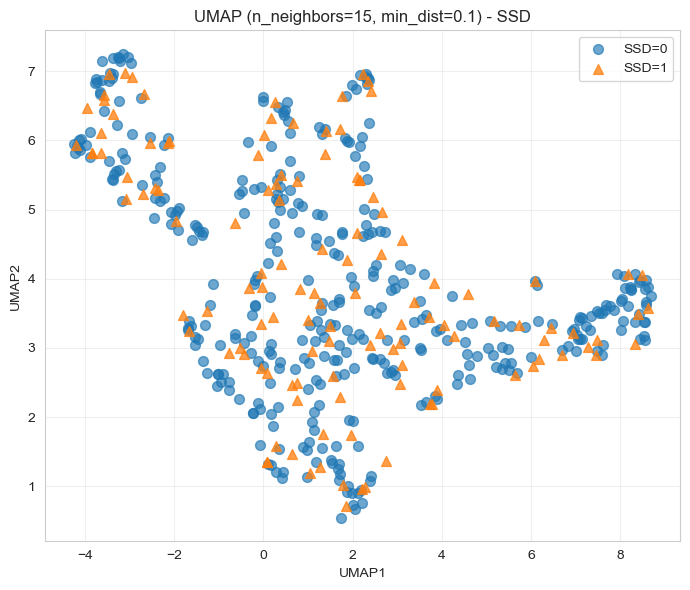

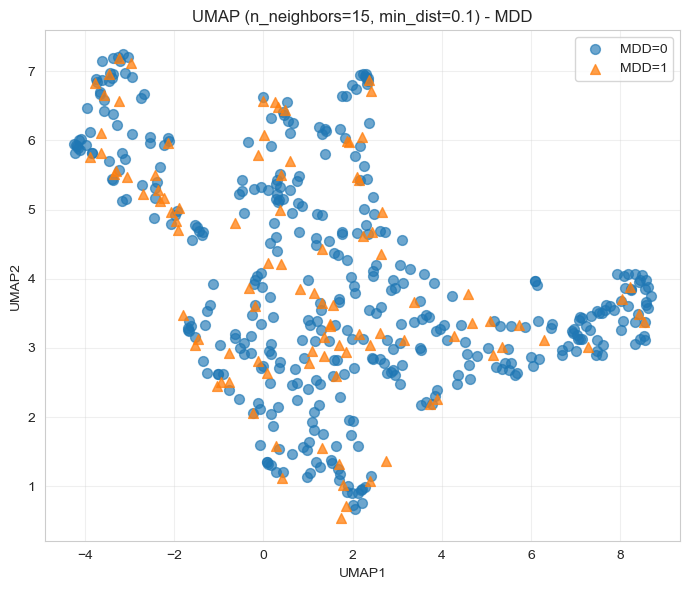

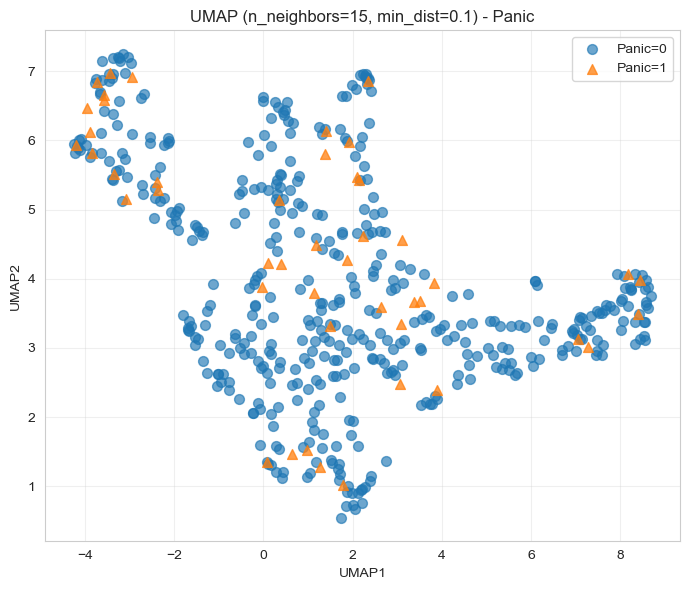

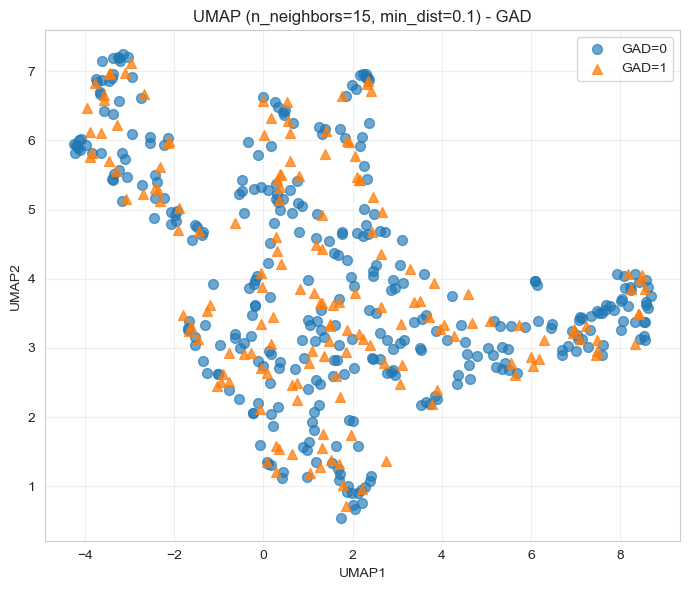

In [8]:
# ==================== 5b. UMAP 非線性降維（用同一組 HRV 特徵，與 PCA 前處理一致） ====================
print("\n[5b] UMAP 非線性降維...")

umap_embedding = None
umap_params = dict(
    n_neighbors=15,      # 鄰居數（越大越看全局，越小越看局部）
    min_dist=0.1,        # 點群緊密程度（小=更緊密）
    n_components=2,      # 2D 投影方便視覺化
    metric="euclidean",
    random_state=42
)

if UMAP_OK:
    # 直接用「已填補 + 已縮放」的 HRV 原始特徵（與 PCA 同一份 X_pca_scaled）
    umap_model = UMAP(**umap_params)
    umap_embedding = umap_model.fit_transform(X_pca_scaled)

    # 存成 DataFrame，並與原 df 對齊索引
    umap_df = pd.DataFrame(umap_embedding, columns=["UMAP1", "UMAP2"], index=df.index)

    # 視覺化：依每個 label 著色
    for label in LABEL_COLS:
        if label not in df.columns:
            continue

        fig, ax = plt.subplots(figsize=(7, 6))
        mask0 = (df[label] == 0)
        mask1 = (df[label] == 1)

        # 只畫有對應標籤的樣本點（避免 NaN）
        valid_mask0 = mask0 & df[label].notna()
        valid_mask1 = mask1 & df[label].notna()

        ax.scatter(umap_df.loc[valid_mask0, "UMAP1"], umap_df.loc[valid_mask0, "UMAP2"],
                   alpha=0.65, s=50, label=f"{label}=0")
        ax.scatter(umap_df.loc[valid_mask1, "UMAP1"], umap_df.loc[valid_mask1, "UMAP2"],
                   alpha=0.75, s=50, label=f"{label}=1", marker="^")

        ax.set_xlabel("UMAP1")
        ax.set_ylabel("UMAP2")
        ax.set_title(f"UMAP (n_neighbors={umap_params['n_neighbors']}, min_dist={umap_params['min_dist']}) - {label}")
        ax.legend()
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(PLOTS_DIR / f"umap_{label}.png", dpi=300, bbox_inches='tight')
        plt.show()

    # 方便後續建模或比對，將 UMAP 座標併回 df（不會覆蓋原欄位）
    df = pd.concat([df, umap_df], axis=1)

else:
    print("UMAP 無法使用（未安裝 umap-learn）。略過本步驟。")


[6] 特徵重要性分析...

SSD 特徵重要性 (Top 10):
                feature  mutual_info  rf_importance  combined_score
2                   BMI     0.022589       0.123742        0.910716
15  Age_BMI_interaction     0.027499       0.079024        0.819310
12                  RSA     0.020325       0.070395        0.654004
9                  LFHF     0.021834       0.061870        0.646988
13          LF_HF_ratio     0.019357       0.061788        0.601617
0                   Age     0.013649       0.065440        0.512598
11                   FT     0.000000       0.105428        0.425999
16        SDNN_SC_ratio     0.000000       0.076591        0.309476
8                    HF     0.000000       0.073128        0.295483
3                    DM     0.015754       0.002097        0.294926


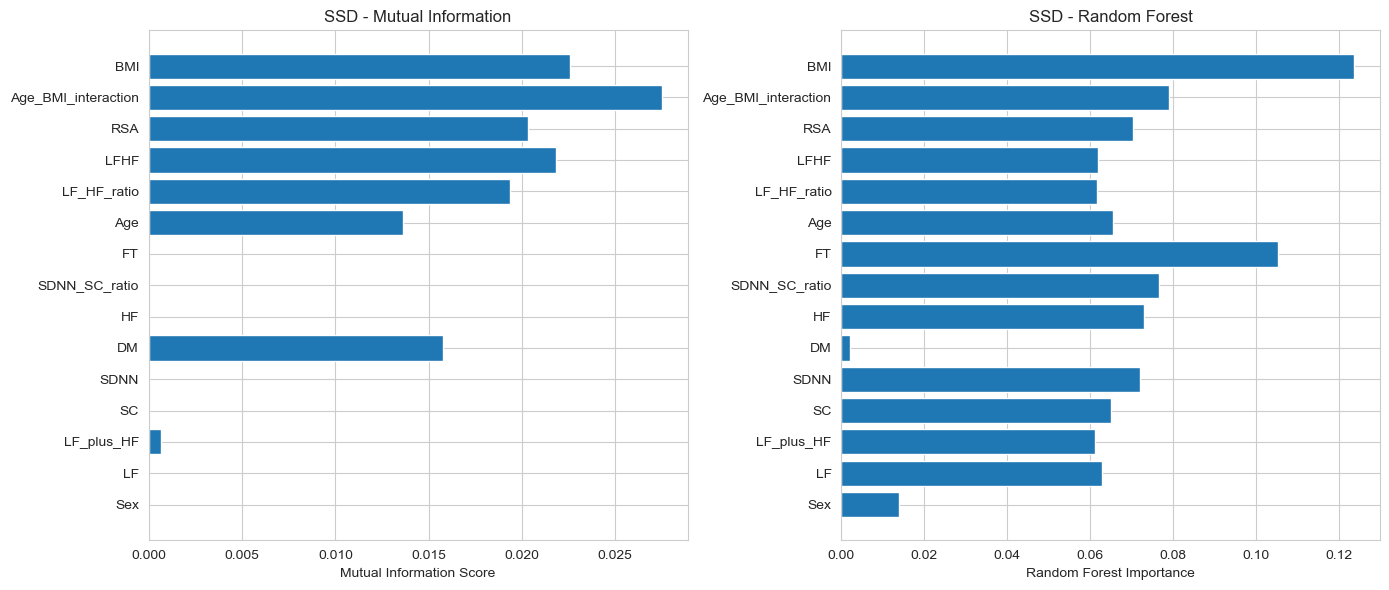


MDD 特徵重要性 (Top 10):
                feature  mutual_info  rf_importance  combined_score
8                    HF     0.021880       0.071768        0.785494
11                   FT     0.010257       0.092345        0.686066
2                   BMI     0.008031       0.089944        0.632685
0                   Age     0.010456       0.075787        0.600018
4                   TCA     0.027563       0.007474        0.540467
15  Age_BMI_interaction     0.003157       0.085678        0.521163
10                   SC     0.006851       0.072767        0.518277
14           LF_plus_HF     0.008435       0.066388        0.512469
12                  RSA     0.000000       0.079716        0.431624
16        SDNN_SC_ratio     0.002440       0.071290        0.430259


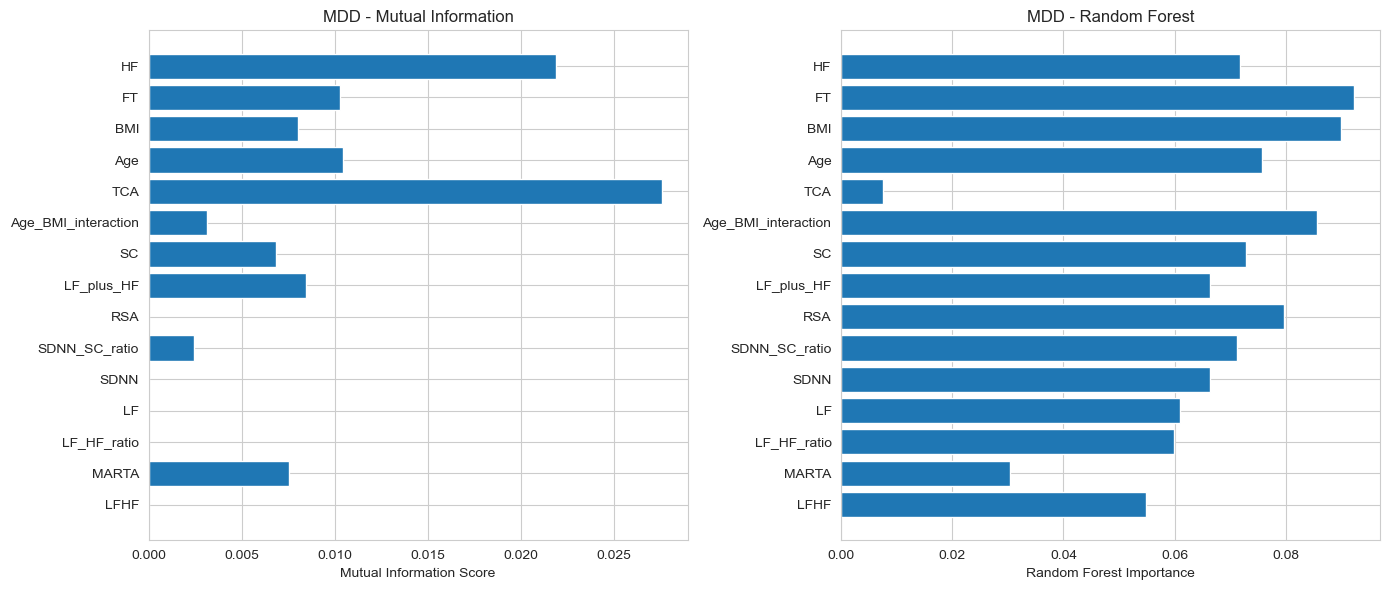


Panic 特徵重要性 (Top 10):
        feature  mutual_info  rf_importance  combined_score
0           Age     0.022451       0.065209        0.811055
14   LF_plus_HF     0.016936       0.063095        0.678145
9          LFHF     0.012399       0.078279        0.649547
11           FT     0.000000       0.104818        0.500000
12          RSA     0.006835       0.068557        0.479247
13  LF_HF_ratio     0.001688       0.090068        0.467242
3            DM     0.018118       0.005367        0.429097
1           Sex     0.016072       0.014727        0.428183
2           BMI     0.000000       0.084742        0.404231
6          SDNN     0.000000       0.079086        0.377254


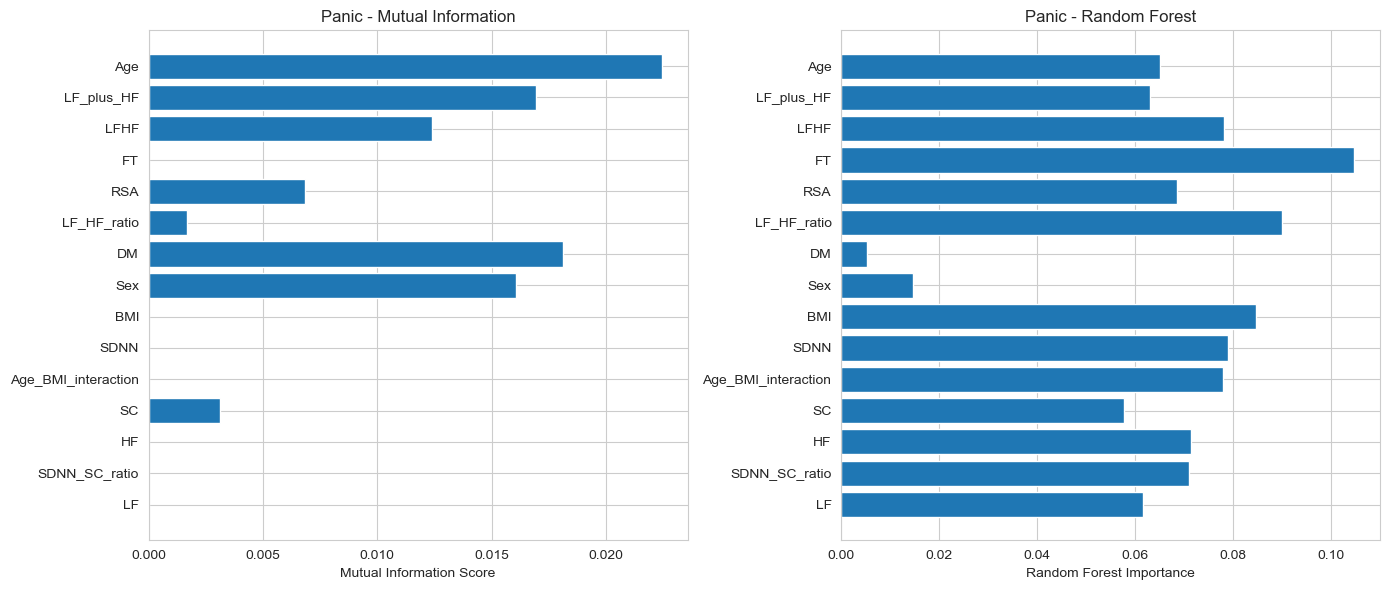


GAD 特徵重要性 (Top 10):
                feature  mutual_info  rf_importance  combined_score
11                   FT     0.021481       0.116942        0.867526
12                  RSA     0.027198       0.089494        0.847977
6                  SDNN     0.029224       0.072268        0.808988
14           LF_plus_HF     0.022243       0.065461        0.660438
13          LF_HF_ratio     0.017283       0.064475        0.571360
16        SDNN_SC_ratio     0.010783       0.072554        0.494703
15  Age_BMI_interaction     0.005914       0.079689        0.441897
9                  LFHF     0.007281       0.063836        0.397513
3                    DM     0.022544       0.002426        0.396086
2                   BMI     0.000000       0.088005        0.376275


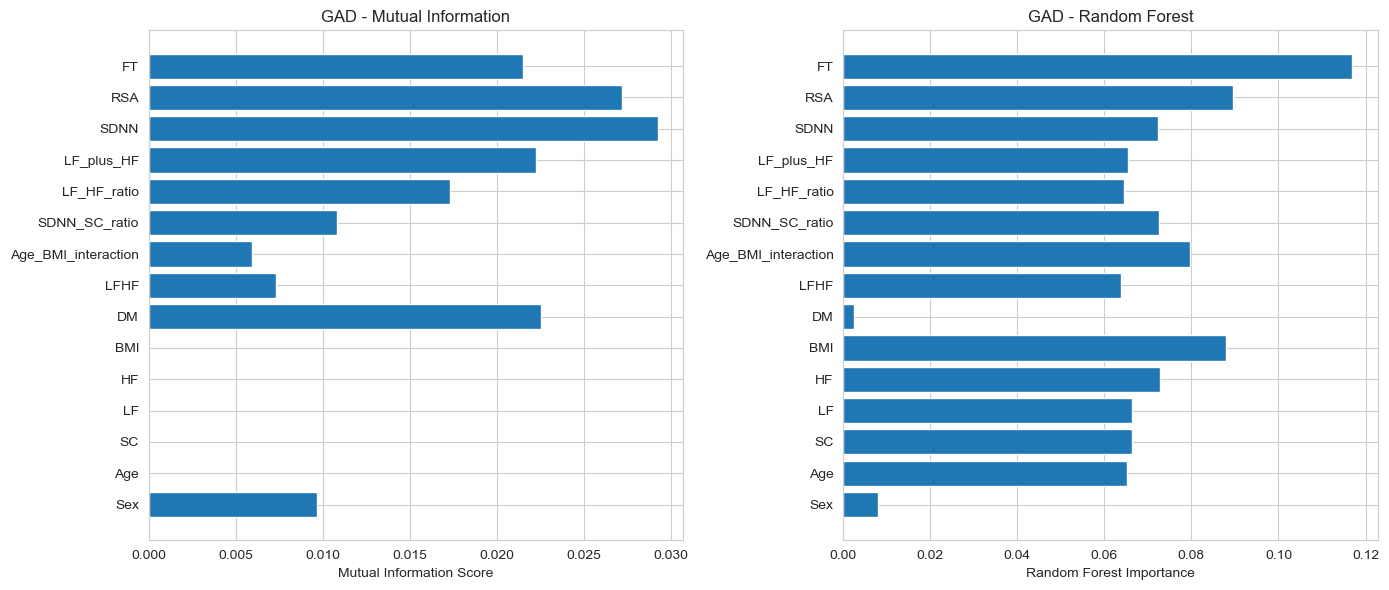

In [9]:
# ==================== 6. 特徵重要性分析 ====================
print("\n[6] 特徵重要性分析...")

feature_importance_results = {}

for label in LABEL_COLS:
    if label not in df.columns:
        continue
    
    # 準備資料
    mask = df[label].notna()
    available_features = [c for c in ALL_FEATURES_EXT if c in df.columns]
    
    X = df.loc[mask, available_features].copy()
    y = df.loc[mask, label].values
    
    # 填補缺失值
    imp = KNNImputer(n_neighbors=5)
    X_filled = pd.DataFrame(imp.fit_transform(X), columns=X.columns)
    
    if len(np.unique(y)) < 2 or len(X) < 20:
        continue
    
    # 使用 mutual information
    mi_scores = mutual_info_classif(X_filled, y, random_state=42)
    
    # 使用 Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_filled, y)
    rf_importance = rf.feature_importances_
    
    # 整合結果
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'mutual_info': mi_scores,
        'rf_importance': rf_importance,
        'combined_score': (mi_scores / mi_scores.max() + rf_importance / rf_importance.max()) / 2
    }).sort_values('combined_score', ascending=False)
    
    feature_importance_results[label] = importance_df
    
    print(f"\n{label} 特徵重要性 (Top 10):")
    print(importance_df.head(10))
    
    # 視覺化
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    top_n = min(15, len(importance_df))
    top_features = importance_df.head(top_n)
    
    ax1.barh(range(top_n), top_features['mutual_info'].values)
    ax1.set_yticks(range(top_n))
    ax1.set_yticklabels(top_features['feature'].values)
    ax1.set_xlabel('Mutual Information Score')
    ax1.set_title(f'{label} - Mutual Information')
    ax1.invert_yaxis()
    
    ax2.barh(range(top_n), top_features['rf_importance'].values)
    ax2.set_yticks(range(top_n))
    ax2.set_yticklabels(top_features['feature'].values)
    ax2.set_xlabel('Random Forest Importance')
    ax2.set_title(f'{label} - Random Forest')
    ax2.invert_yaxis()
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / f"feature_importance_{label}.png", dpi=300, bbox_inches='tight')
    plt.show()

In [10]:
# ==================== 7. 改進的二元分類模型 ====================
print("\n[7] 改進的二元分類模型...")

def enhanced_binary_classification(df, label, feature_cols, use_smote=True, top_k_features=None):
    """
    增強版二元分類
    - 使用多種模型
    - SMOTE 處理不平衡
    - 特徵選擇
    - 超參數調整
    """
    # 準備資料
    mask = df[label].notna()
    X = df.loc[mask, feature_cols].copy()
    y = df.loc[mask, label].values.astype(int)
    
    # 填補缺失值
    imp = KNNImputer(n_neighbors=5)
    X_filled = pd.DataFrame(imp.fit_transform(X), columns=X.columns)
    
    if len(np.unique(y)) < 2 or len(X) < 30:
        return None
    
    # 特徵選擇 (如果指定)
    if top_k_features and top_k_features < len(feature_cols):
        selector = SelectKBest(f_classif, k=top_k_features)
        X_selected = selector.fit_transform(X_filled, y)
        selected_features = X_filled.columns[selector.get_support()].tolist()
        print(f"  選擇的特徵: {selected_features}")
    else:
        X_selected = X_filled.values
        selected_features = feature_cols
    
    # 資料分割
    X_train, X_test, y_train, y_test = train_test_split(
        X_selected, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # 標準化
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 處理不平衡 (SMOTE)
    if use_smote and np.sum(y_train == 1) >= 2:
        try:
            smote = SMOTE(random_state=42, k_neighbors=min(5, np.sum(y_train == 1) - 1))
            X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)
            print(f"  SMOTE: {len(y_train)} -> {len(y_train_balanced)} 樣本")
        except:
            X_train_balanced, y_train_balanced = X_train_scaled, y_train
    else:
        X_train_balanced, y_train_balanced = X_train_scaled, y_train
    
    results = {}
    
    # 定義多個模型
    models = {
        'Logistic Regression': LogisticRegression(max_iter=2000, random_state=42, class_weight='balanced'),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
        'SVM': SVC(probability=True, random_state=42, class_weight='balanced')
    }
    
    # 訓練和評估每個模型
    for model_name, model in models.items():
        # 交叉驗證
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_validate(
            model, X_train_balanced, y_train_balanced,
            cv=cv,
            scoring=['roc_auc', 'average_precision', 'f1'],
            n_jobs=-1
        )
        
        # 訓練最終模型
        model.fit(X_train_balanced, y_train_balanced)
        
        # 測試集預測
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        y_pred = model.predict(X_test_scaled)
        
        # 計算指標
        test_auc = roc_auc_score(y_test, y_pred_proba)
        test_ap = average_precision_score(y_test, y_pred_proba)
        test_f1 = f1_score(y_test, y_pred)
        
        results[model_name] = {
            'cv_auc_mean': np.mean(cv_scores['test_roc_auc']),
            'cv_auc_std': np.std(cv_scores['test_roc_auc']),
            'cv_ap_mean': np.mean(cv_scores['test_average_precision']),
            'cv_f1_mean': np.mean(cv_scores['test_f1']),
            'test_auc': test_auc,
            'test_ap': test_ap,
            'test_f1': test_f1,
            'n_train': len(y_train_balanced),
            'n_test': len(y_test)
        }
        
        print(f"\n  {model_name}:")
        print(f"    CV AUC: {results[model_name]['cv_auc_mean']:.3f} ± {results[model_name]['cv_auc_std']:.3f}")
        print(f"    Test AUC: {test_auc:.3f}, AP: {test_ap:.3f}, F1: {test_f1:.3f}")
    
    return results

# 對每個標籤進行分類
all_classification_results = {}

for label in LABEL_COLS:
    if label not in df.columns:
        continue
    
    print(f"\n處理 {label}...")
    
    available_features = [c for c in ALL_FEATURES_EXT if c in df.columns]
    
    # 使用全部特徵
    results_all = enhanced_binary_classification(
        df, label, available_features, 
        use_smote=True, 
        top_k_features=None
    )
    
    if results_all:
        all_classification_results[label] = results_all


[7] 改進的二元分類模型...

處理 SSD...
  SMOTE: 401 -> 604 樣本

  Logistic Regression:
    CV AUC: 0.656 ± 0.050
    Test AUC: 0.598, AP: 0.367, F1: 0.416

  Random Forest:
    CV AUC: 0.888 ± 0.025
    Test AUC: 0.591, AP: 0.306, F1: 0.345

  Gradient Boosting:
    CV AUC: 0.817 ± 0.019
    Test AUC: 0.602, AP: 0.320, F1: 0.387

  SVM:
    CV AUC: 0.769 ± 0.061
    Test AUC: 0.598, AP: 0.407, F1: 0.347

處理 MDD...
  SMOTE: 401 -> 642 樣本

  Logistic Regression:
    CV AUC: 0.748 ± 0.016
    Test AUC: 0.578, AP: 0.285, F1: 0.361

  Random Forest:
    CV AUC: 0.944 ± 0.027
    Test AUC: 0.593, AP: 0.244, F1: 0.211

  Gradient Boosting:
    CV AUC: 0.912 ± 0.025
    Test AUC: 0.581, AP: 0.258, F1: 0.233

  SVM:
    CV AUC: 0.827 ± 0.027
    Test AUC: 0.573, AP: 0.240, F1: 0.255

處理 Panic...
  SMOTE: 401 -> 728 樣本

  Logistic Regression:
    CV AUC: 0.657 ± 0.021
    Test AUC: 0.473, AP: 0.114, F1: 0.111

  Random Forest:
    CV AUC: 0.986 ± 0.008
    Test AUC: 0.512, AP: 0.257, F1: 0.200

  Gradient 


[8] 結果彙整...

完整模型比較:
    Label                Model         CV_AUC Test_AUC Test_AP Test_F1  N_Train  N_Test
0     SSD  Logistic Regression  0.656 ± 0.050    0.598   0.367   0.416      604     101
1     SSD        Random Forest  0.888 ± 0.025    0.591   0.306   0.345      604     101
2     SSD    Gradient Boosting  0.817 ± 0.019    0.602   0.320   0.387      604     101
3     SSD                  SVM  0.769 ± 0.061    0.598   0.407   0.347      604     101
4     MDD  Logistic Regression  0.748 ± 0.016    0.578   0.285   0.361      642     101
5     MDD        Random Forest  0.944 ± 0.027    0.593   0.244   0.211      642     101
6     MDD    Gradient Boosting  0.912 ± 0.025    0.581   0.258   0.233      642     101
7     MDD                  SVM  0.827 ± 0.027    0.573   0.240   0.255      642     101
8   Panic  Logistic Regression  0.657 ± 0.021    0.473   0.114   0.111      728     101
9   Panic        Random Forest  0.986 ± 0.008    0.512   0.257   0.200      728     101
10  Panic 

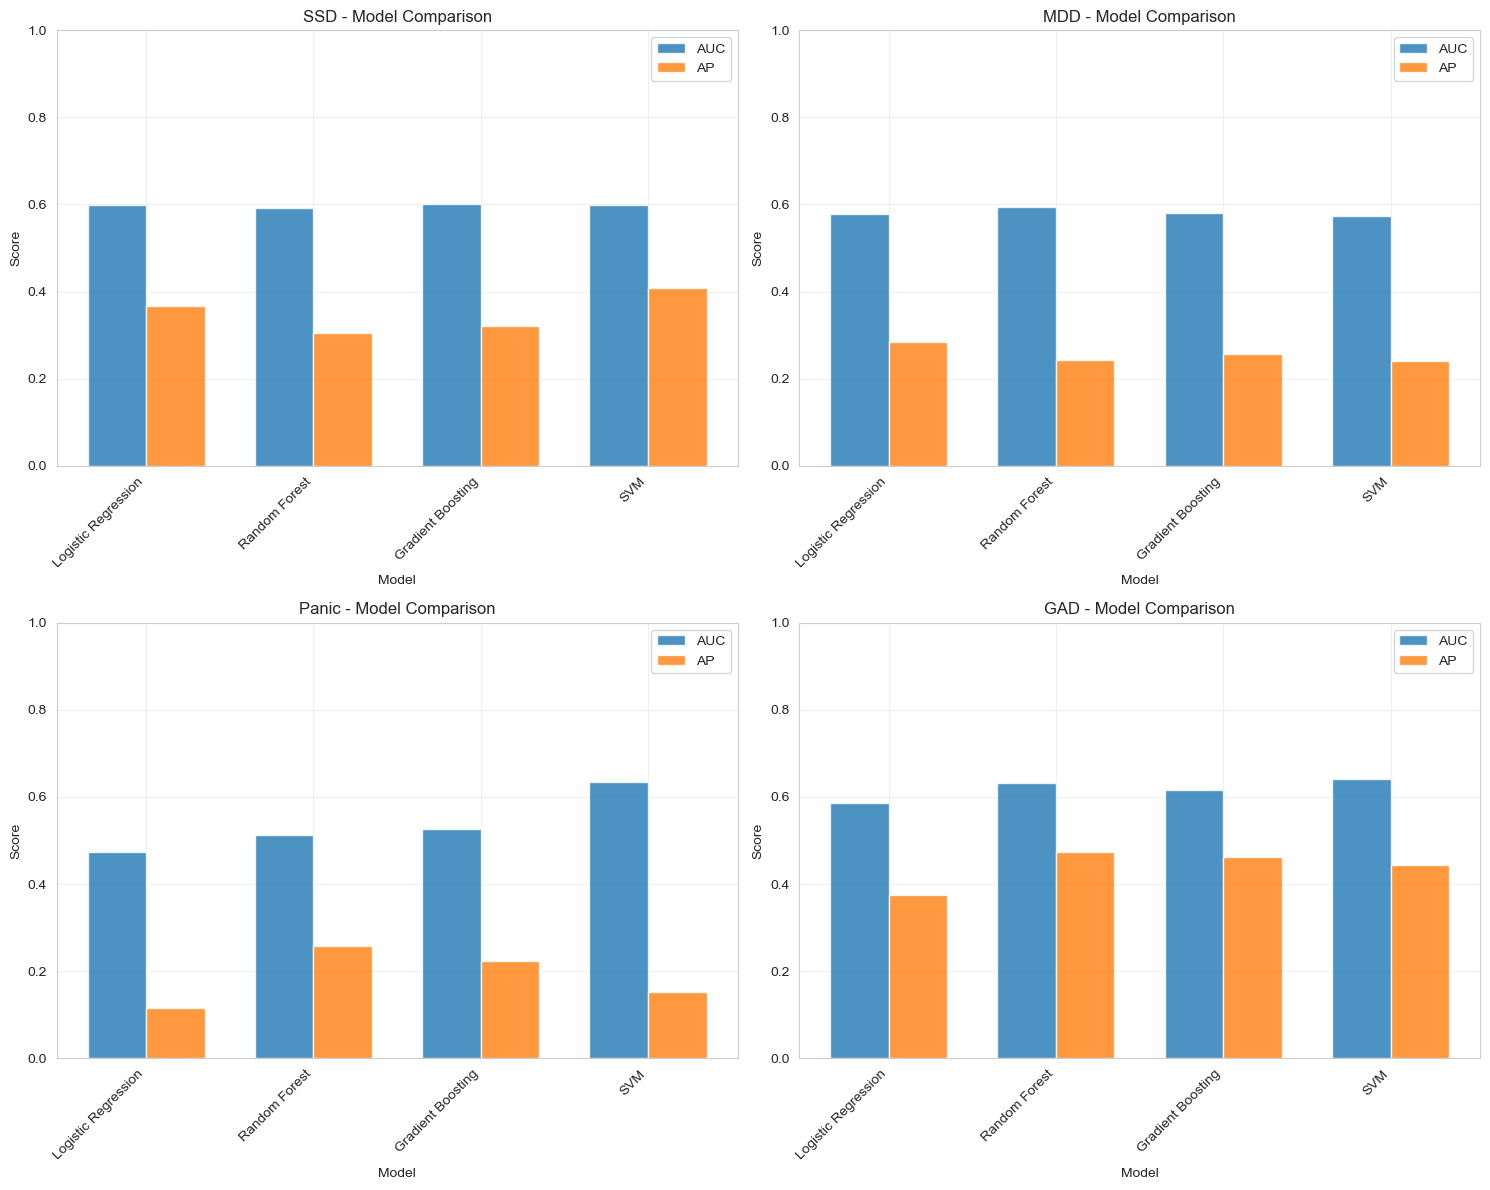

In [11]:
# ==================== 8. 結果彙整與視覺化 ====================
print("\n[8] 結果彙整...")

# 建立比較表格
comparison_rows = []
for label, model_results in all_classification_results.items():
    for model_name, metrics in model_results.items():
        comparison_rows.append({
            'Label': label,
            'Model': model_name,
            'CV_AUC': f"{metrics['cv_auc_mean']:.3f} ± {metrics['cv_auc_std']:.3f}",
            'Test_AUC': f"{metrics['test_auc']:.3f}",
            'Test_AP': f"{metrics['test_ap']:.3f}",
            'Test_F1': f"{metrics['test_f1']:.3f}",
            'N_Train': metrics['n_train'],
            'N_Test': metrics['n_test']
        })

comparison_df = pd.DataFrame(comparison_rows)
print("\n完整模型比較:")
print(comparison_df.to_string())

# 視覺化最佳模型表現
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, label in enumerate(LABEL_COLS):
    if label in all_classification_results:
        results = all_classification_results[label]
        
        models = list(results.keys())
        aucs = [results[m]['test_auc'] for m in models]
        aps = [results[m]['test_ap'] for m in models]
        
        x = np.arange(len(models))
        width = 0.35
        
        axes[idx].bar(x - width/2, aucs, width, label='AUC', alpha=0.8)
        axes[idx].bar(x + width/2, aps, width, label='AP', alpha=0.8)
        axes[idx].set_xlabel('Model')
        axes[idx].set_ylabel('Score')
        axes[idx].set_title(f'{label} - Model Comparison')
        axes[idx].set_xticks(x)
        axes[idx].set_xticklabels(models, rotation=45, ha='right')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)
        axes[idx].set_ylim([0, 1])

plt.tight_layout()
plt.savefig(PLOTS_DIR / "model_comparison_all_labels.png", dpi=300, bbox_inches='tight')
plt.show()

In [12]:
# ==================== 9. 儲存結果 ====================
print("\n[9] 儲存結果...")

with pd.ExcelWriter(OUT_XLSX, engine="xlsxwriter") as writer:
    # 1) 模型比較（若有結果）
    if 'comparison_df' in globals() and isinstance(comparison_df, pd.DataFrame) and not comparison_df.empty:
        comparison_df.to_excel(writer, sheet_name="Model_Comparison", index=False)
    else:
        pd.DataFrame({"msg": ["no model results"]}).to_excel(writer, sheet_name="Model_Comparison", index=False)

    # 2) PCA 解釋變異量（若有結果）
    if 'explained_var' in globals() and isinstance(explained_var, pd.DataFrame) and not explained_var.empty:
        explained_var.to_excel(writer, sheet_name="PCA_Variance", index=False)

    # 3) 特徵重要性（逐標籤寫一張 sheet；若沒有就跳過）
    if 'feature_importance_results' in globals() and isinstance(feature_importance_results, dict):
        for label, imp_df in feature_importance_results.items():
            if isinstance(imp_df, pd.DataFrame) and not imp_df.empty:
                sheet_name = f"Feature_Imp_{label}"[:31]  # Excel 工作表名稱長度限制
                imp_df.to_excel(writer, sheet_name=sheet_name, index=False)

    # 4) 缺失值報告
    if 'missing_report' in globals() and isinstance(missing_report, pd.DataFrame):
        missing_report.to_excel(writer, sheet_name="Missing_Report", index=False)

    # 5) UMAP 座標（若你前面已加入 UMAP）
    if 'df' in globals() and {'UMAP1', 'UMAP2'}.issubset(set(df.columns)):
        cols_to_save = ['UMAP1', 'UMAP2'] + [c for c in LABEL_COLS if c in df.columns]
        df[cols_to_save].to_excel(writer, sheet_name="UMAP_Embedding", index=False)

print(f"✓ 結果已儲存至: {OUT_XLSX}")
print(f"✓ 圖表已儲存至: {PLOTS_DIR}")

print("\n" + "=" * 80)
print("分析完成!")
print("=" * 80)

# 輸出最佳模型建議（更穩健：避免空結果 / 無法比較時報錯）
print("\n最佳模型建議:")
has_any = False
for label in LABEL_COLS:
    if label in all_classification_results and all_classification_results[label]:
        results = all_classification_results[label]
        if len(results) > 0:
            best_model = max(results.items(), key=lambda x: x[1].get('test_auc', float('-inf')))
            print(f"  {label}: {best_model[0]} (AUC={best_model[1].get('test_auc', float('nan')):.3f})")
            has_any = True

if not has_any:
    print("  （尚無可用的模型結果）")


[9] 儲存結果...
✓ 結果已儲存至: D:\FLY114\Data_Improved\enhanced_analysis_summary.xlsx
✓ 圖表已儲存至: D:\FLY114\Data_Improved\enhanced_plots

分析完成!

最佳模型建議:
  SSD: Gradient Boosting (AUC=0.602)
  MDD: Random Forest (AUC=0.593)
  Panic: SVM (AUC=0.634)
  GAD: SVM (AUC=0.642)
